**此notebook是在transformer建模后回来写的。发现也许有很多可以优化的地方。所以重新写了一版。**



In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
import time
import numpy as np
import tensorflow as tf
from utils.preprocess import load_testcnn_data, load_tokenizer_binarizer
tf.__version__

'2.0.0'

# 训练

## 构建数据集

In [3]:
train_x, dev_x, test_x, train_y, dev_y, test_y = load_testcnn_data()
tokenizer, mlb = load_tokenizer_binarizer()
BUFFER_SIZE = 256
BATCH_SIZE = 256

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False)

# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 设定超参并建模

In [5]:
from textcnn.model import TextCNN

In [6]:
max_len = 128
vocab_size = 50000
embedding_dim=256
output_dim = len(train_y[0])  # 97
kernel_sizes = [2, 3, 4]
learning_rate = 0.01
epochs = 20
steps_per_epoch = len(train_x) // BATCH_SIZE

In [7]:
model = TextCNN(max_len=max_len, 
                vocab_size=vocab_size, 
                embedding_dim=embedding_dim, 
                output_dim=output_dim, 
                kernel_sizes=kernel_sizes)

## 损失函数、学习率 、评估指标、

In [8]:
# loss_object = tf.keras.losses.CategoricalCrossentropy()  # 多分类
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # 多标签分类
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [9]:
from utils.metrics import micro_f1, macro_f1
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='auto')

In [10]:
from textcnn.train import predict, evaluation

In [11]:
train_step_signature = [
    tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(x, y):

    with tf.GradientTape() as tape:
        y_pred = model(x)  # 和transformer的区别
        loss = loss_object(y, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, y_pred)

    mi_f1=micro_f1(y, y_pred)
    ma_f1=macro_f1(y, y_pred)
    return mi_f1, ma_f1, y_pred

loss_record = []
# 为了之后绘制曲线
dev_micro = []
dev_macro = []

train_micro = []
train_macro = []

for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    train_y_true = []
    train_y_pred = []
    
    
    for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
        mi_f1 ,ma_f1, y_pred = train_step(x, y)
        
        train_y_pred.append(y_pred)
        train_y_true.append(y)
        if batch % 20 == 0:
            print('epoch {} batch {:3d} loss {:.4f} acc {:.4f} micro_f1 {:.4f} macro_f1 {:.4f}'.format(
                epoch+1, batch+1, train_loss.result(), 
                train_accuracy.result(), mi_f1, ma_f1))

    loss_record.append(train_loss.result().numpy())  # 记录下每轮loss的变化
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    
    _, mi, ma = evaluation(model, dev_x, dev_y)
    
    train_y_true = tf.concat(train_y_true, axis=0)
    train_y_pred = tf.concat(train_y_pred, axis=0)
    
    dev_micro.append(mi.numpy())
    dev_macro.append(ma.numpy())
    train_micro.append(micro_f1(train_y_true, train_y_pred).numpy())
    train_macro.append(macro_f1(train_y_true, train_y_pred).numpy())
    
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

epoch 1 batch   1 loss 0.6966 acc 0.9561 micro_f1 0.0000 macro_f1 0.0000
epoch 1 batch  21 loss 0.4200 acc 0.9469 micro_f1 0.0163 macro_f1 0.0044
epoch 1 batch  41 loss 0.2892 acc 0.9537 micro_f1 0.2828 macro_f1 0.0401
epoch 1 batch  61 loss 0.2334 acc 0.9575 micro_f1 0.4012 macro_f1 0.0653
Epoch 1 Loss 0.2110
val accuracy 0.9693, micro f1 0.4849 macro f1 0.0949
Time taken for 1 epoch 17.61 sec

epoch 2 batch   1 loss 0.1004 acc 0.9693 micro_f1 0.5261 macro_f1 0.0909
epoch 2 batch  21 loss 0.0911 acc 0.9708 micro_f1 0.4997 macro_f1 0.1384
epoch 2 batch  41 loss 0.0850 acc 0.9720 micro_f1 0.6286 macro_f1 0.2218
epoch 2 batch  61 loss 0.0792 acc 0.9735 micro_f1 0.6739 macro_f1 0.2744
Epoch 2 Loss 0.0763
val accuracy 0.9777, micro f1 0.6734 macro f1 0.3125
Time taken for 1 epoch 14.28 sec

epoch 3 batch   1 loss 0.0596 acc 0.9788 micro_f1 0.7107 macro_f1 0.3073
epoch 3 batch  21 loss 0.0578 acc 0.9798 micro_f1 0.7361 macro_f1 0.3871
epoch 3 batch  41 loss 0.0564 acc 0.9800 micro_f1 0.7390

# 绘图

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
history = pd.DataFrame([loss_record, dev_micro, dev_macro, train_micro, train_macro],
                        index=['train_loss', 'dev_micro', 'dev_macro', 'train_micro', 'train_macro']).T
history.index += 1

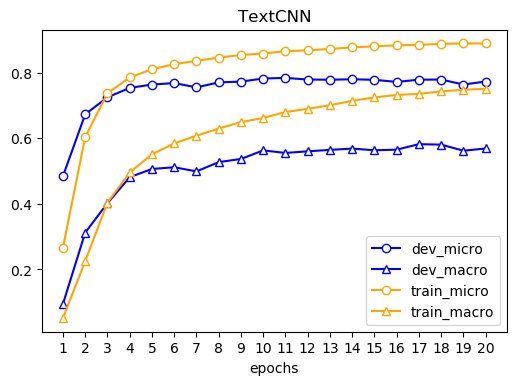

In [27]:
fig, ax = plt.subplots(dpi=100)
ax.plot(history.dev_micro, c='b', marker='o', mfc='w', label='dev_micro')
ax.plot(history.dev_macro, c='b', marker='^', mfc='w', label='dev_macro')
ax.plot(history.train_micro, c='orange', marker='o', mfc='w', label='train_micro')
ax.plot(history.train_macro, c='orange', marker='^', mfc='w', label='train_macro')
ax.set_title('TextCNN')
ax.set_xlabel('epochs')
ax.set_xticks(history.index)
plt.legend()
plt.show()

In [26]:
history.to_csv('notebook/TextCNN/textcnn_report.csv', index=None)

# 预测

In [23]:
y_pred = predict(model, test_x)

In [24]:
mif1 = micro_f1(tf.cast(test_y, dtype=tf.float32), y_pred)
maf1 = macro_f1(tf.cast(test_y, dtype=tf.float32), y_pred)

In [25]:
print('test micro f1: {:.4f} macro f1: {:.4f}'.format(mif1.numpy(), maf1.numpy()))

test micro f1: 0.7718 macro f1: 0.5630
